In [2]:
!pip3 install statsmodels --upgrade

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [3]:
print(__doc__)

import scipy.stats as scp_stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.special import expit
import statsmodels.api as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

import missingno as msno
import seaborn as sns

# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format
df = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/ML-for-COVID-19-dataset/main/all_training.csv", sep=',')

Automatically created module for IPython interactive environment


In [4]:
#Using robust scaling as normalization method

# Column selection
df_features = df.iloc[:,np.r_[3,5:34]].copy()

# create a scaler object
scaler = RobustScaler()

# fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
n_samples, n_features = df_features.shape

# How many nan values are there?
df_normalized.isna().sum()

CA       93
CREA     74
ALP     474
GGT     436
GLU      98
AST      98
ALT      96
LDH     303
PCR      97
KAL      80
NAT      73
UREA    676
WBC      63
RBC      63
HGB      63
HCT      63
MCV      63
MCH      63
MCHC     63
PLT1     63
NE      362
LY      362
MO      362
EO      362
BA      362
NET     362
LYT     362
MOT     362
EOT     362
BAT     362
dtype: int64

<AxesSubplot:>

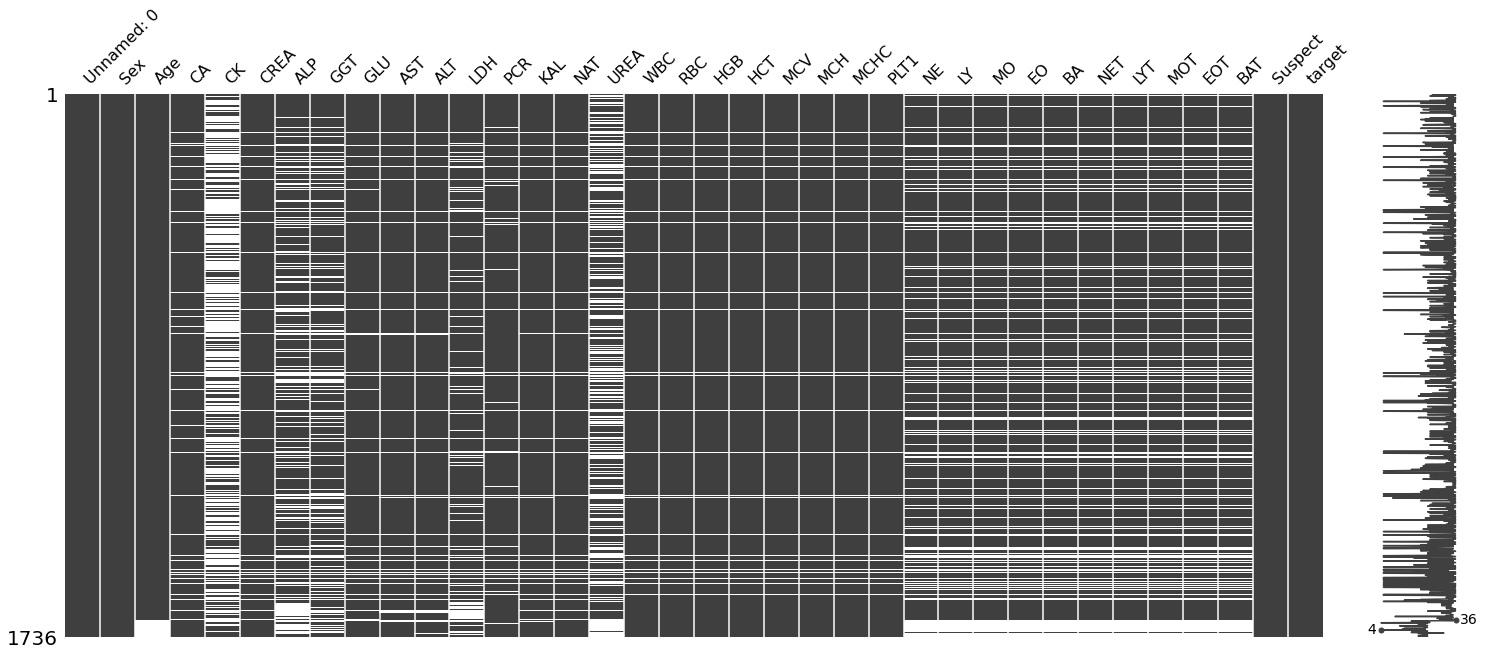

In [5]:
%matplotlib inline
msno.matrix(df)
# msno.matrix(df_normalized)

In [6]:
# define row and column index
col = df_normalized.columns
row = [i for i in range(df_normalized.shape[0])]

# define imputer
imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# fit on the dataset
imputer.fit(df_normalized)

# transform the dataset
df_normalized_imputed = imputer.transform(df_normalized)

# convert back to pandas dataframe and rename back to df_normalized
df_normalized = pd.DataFrame(data=df_normalized_imputed, index=row, columns=col)

# how many values does the imputation fix?
df_normalized.isna().sum()

/Users/wenxuanhuang/Library/Python/3.8/lib/python/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


CA      0
CREA    0
ALP     0
GGT     0
GLU     0
AST     0
ALT     0
LDH     0
PCR     0
KAL     0
NAT     0
UREA    0
WBC     0
RBC     0
HGB     0
HCT     0
MCV     0
MCH     0
MCHC    0
PLT1    0
NE      0
LY      0
MO      0
EO      0
BA      0
NET     0
LYT     0
MOT     0
EOT     0
BAT     0
dtype: int64

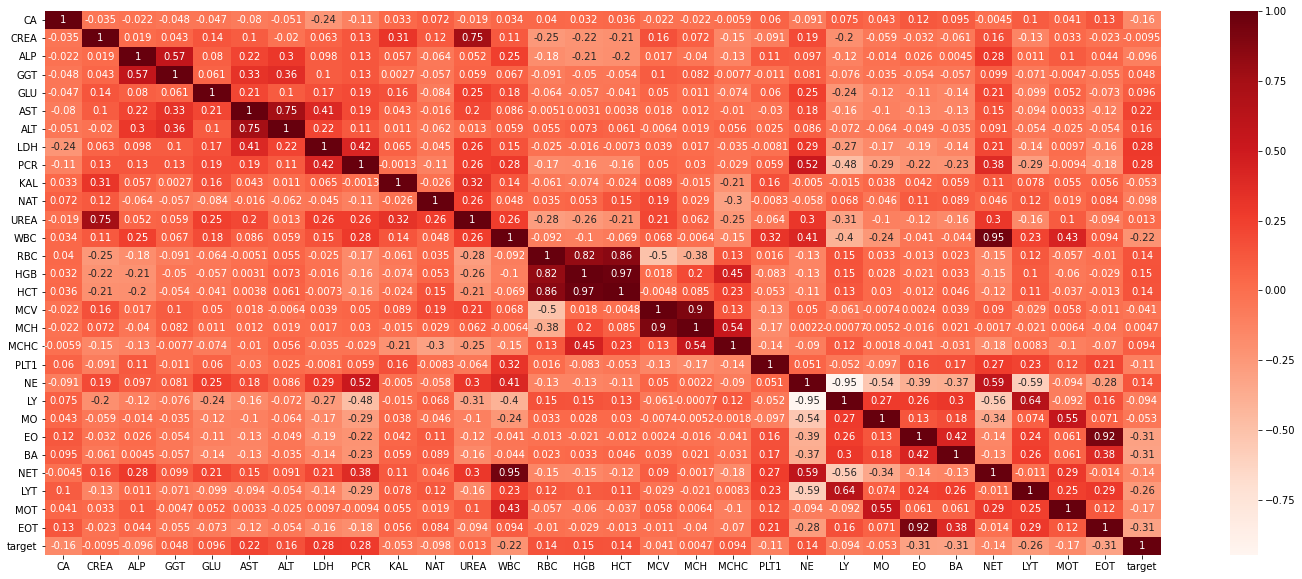

In [7]:
# Pearson correlation for feature selection
plt.figure(figsize=(25,10))
df_pearson = df.iloc[:,np.r_[3,5:33,35]].copy()
cor = df_pearson.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

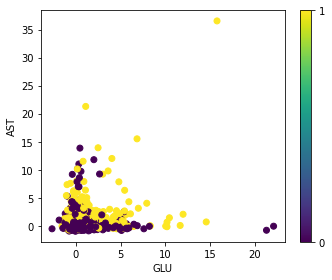

In [8]:
# The indices of the features that we are plotting
x_index = 4
y_index = 5

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: df.target.unique()[int(i)])

plt.figure(figsize=(5, 4))
plt.scatter(df_normalized.iloc[:, x_index], df_normalized.iloc[:, y_index], c=df.target)
plt.colorbar(ticks=[0, 1], format=formatter)
plt.xlabel(df_normalized.columns[x_index])
plt.ylabel(df_normalized.columns[y_index])

plt.tight_layout()
plt.show()

(array([920.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 816.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

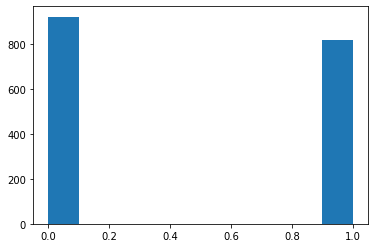

In [9]:
# Plotting histogram
plt.hist(df.target)

In [10]:
# # Plotting target dist for each features
# for index, feature_name in enumerate(df_normalized.columns):
#     plt.figure()
#     plt.scatter(df_normalized.iloc[:, index], df.target)
#     plt.xlabel(df_normalized.columns[index])
#     plt.ylabel("Target")
#     plt.tight_layout()
#     plt.show()

In [20]:
# Logistic regression

# Data preparation
X = df_normalized
y = df.target

# Recursive feature elimination
logreg = linear_model.LogisticRegression()
rfe = RFE(logreg,10)
rfe = rfe.fit(df_normalized, y.values.ravel())
print(rfe.support_)
# print(rfe.ranking_)

# Drop columns that failed RFE test
col = df_normalized.columns[rfe.support_]
X = X[col]
X = X.to_numpy()

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# The line is disabled since single column has not been specified 
#X = X[:, np.newaxis]

/Users/wenxuanhuang/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
[ True False False False False False False  True  True False False False
  True  True False  True False False False  True  True False False False
  True  True False False False False]


In [21]:
X_train_sm = sm.add_constant(X_train)
log_smmodel = sm.Logit(y_train, X_train_sm, family = sm.families.Binomial())
res = log_smmodel.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.477723
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1215
Model:                          Logit   Df Residuals:                     1204
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                  0.3083
Time:                        19:47:07   Log-Likelihood:                -580.43
converged:                       True   LL-Null:                       -839.20
Covariance Type:            nonrobust   LLR p-value:                7.912e-105
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2217      0.115     -1.927      0.054      -0.447       0.004
x1            -1.2536      0.144     -8.707      0.000      -1.536      -0.971
x2             0.4419      0.121      3.649      0.000       0.205       0.679
x3             0.6519      0.124      5.261      0.000       0.409       0.895
x4            -1.2959      0.459     -2.823      0.005      -2.196      -0.396
x5             0.4314      0.186      2.325      0.020       0.068       0.795
x6             0.5449      0.196      2.777      0.005       0.160       0.929
x7             0.2437      0.100      2.439      0.015       0.048       0.440
x8            -0.1130      0.229     -0.493      0.622      -0.562       0.336
x9            -0.4317      0.094     -4.616      0.000      -0.615      -0.248
x10            0.1872      0.511      0.367      0.714      -0.814       1.188
==============================================================================
"""

In [22]:
y_train_pred = res.predict(sm.add_constant(X_train))
y_train_pred[:10]

array([0.28726274, 0.69249685, 0.89597795, 0.46697487, 0.28222717,
       0.80783589, 0.15582167, 0.64619368, 0.06134027, 0.69988611])

In [23]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted
0,0,0.3,0
1,1,0.7,1
2,1,0.9,1
3,1,0.5,0
4,0,0.3,0


In [24]:
# Model Accuracy: How often is the classifier correct?
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))


0.8123456790123457


In [25]:
TP = confusion[1,1]  
TN = confusion[0,0] 
FP = confusion[0,1] 
FN = confusion[1,0]

# True positive rate and true negative rate
print(TP/(TP+FN),TN/(TN+FP))

0.7575221238938054 0.86


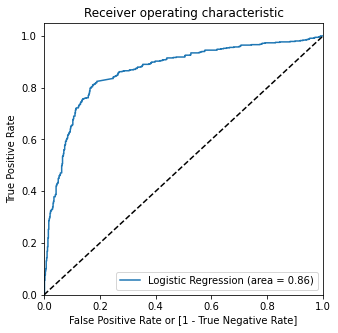

In [26]:
# ROC function plot

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)